# Linear Regression

Turing is powerful when applied to complex hierarchical models, but it can also be put to task at common statistical procedures, like [linear regression](https://en.wikipedia.org/wiki/Linear_regression). This tutorial covers how to implement a linear regression model in Turing.

## Set Up

We begin by importing all the necessary libraries.

In [1]:
# Import Turing and Distributions.
using Turing, Distributions

# Import RDatasets.
using RDatasets

# Import MCMCChains, Plots, and StatPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(0);

# Hide the progress prompt while sampling.
Turing.turnprogress(false);

┌ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]
└ @ Base loading.jl:1260
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1260
┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/cameron/.julia/packages/Turing/cReBm/src/Turing.jl:22


We will use the `mtcars` dataset from the [RDatasets](https://github.com/johnmyleswhite/RDatasets.jl) package. `mtcars` contains a variety of statistics on different car models, including their miles per gallon, number of cylinders, and horsepower, among others.

We want to know if we can construct a Bayesian linear regression model to predict the miles per gallon of a car, given the other statistics it has. Lets take a look at the data we have.

In [2]:
# Import the "Default" dataset.
data = RDatasets.dataset("datasets", "mtcars");

# Show the first six rows of the dataset.
first(data, 6)

,Model,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,String,Float64,Int64,Float64,Int64,Float64,Float64,Float64,Int64
1,Mazda RX4,21.0,6,160.0,110,3.9,2.62,16.46,0
2,Mazda RX4 Wag,21.0,6,160.0,110,3.9,2.875,17.02,0
3,Datsun 710,22.8,4,108.0,93,3.85,2.32,18.61,1
4,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1
5,Hornet Sportabout,18.7,8,360.0,175,3.15,3.44,17.02,0
6,Valiant,18.1,6,225.0,105,2.76,3.46,20.22,1


In [3]:
size(data)

(32, 12)

The next step is to get our data ready for testing. We'll split the `mtcars` dataset into two subsets, one for training our model and one for evaluating our model. Then, we separate the labels we want to learn (`MPG`, in this case) and standardize the datasets by subtracting each column's means and dividing by the standard deviation of that column.

The resulting data is not very familiar looking, but this standardization process helps the sampler converge far easier. We also create a function called `unstandardize`, which returns the standardized values to their original form. We will use this function later on when we make predictions.

In [4]:
# Function to split samples.
function split_data(df, at = 0.70)
    r = size(df,1)
    index = Int(round(r * at))
    train = df[1:index, :]
    test  = df[(index+1):end, :]
    return train, test
end

# A handy helper function to rescale our dataset.
function standardize(x)
    return (x .- mean(x, dims=1)) ./ std(x, dims=1), x
end

# Another helper function to unstandardize our datasets.
function unstandardize(x, orig)
    return (x .+ mean(orig, dims=1)) .* std(orig, dims=1)
end

# Remove the model column.
select!(data, Not(:Model))

# Standardize our dataset.
(std_data, data_arr) = standardize(Matrix(data))

# Split our dataset 70%/30% into training/test sets.
train, test = split_data(std_data, 0.7)

# Save dataframe versions of our dataset.
train_cut = DataFrame(train, names(data))
test_cut = DataFrame(test, names(data))

# Create our labels. These are the values we are trying to predict.
train_label = train_cut[:, :MPG]
test_label = test_cut[:, :MPG]

# Get the list of columns to keep.
remove_names = filter(x->!in(x, [:MPG, :Model]), names(data))

# Filter the test and train sets.
train = Matrix(train_cut[:,remove_names]);
test = Matrix(test_cut[:,remove_names]);

## Model Specification

In a traditional frequentist model using [OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares), our model might look like:

$$
MPG_i = \alpha + \boldsymbol{\beta}^T\boldsymbol{X_i}
$$

where $\boldsymbol{\beta}$ is a vector of coefficients and $\boldsymbol{X}$ is a vector of inputs for observation $i$. The Bayesian model we are more concerned with is the following:

$$
MPG_i \sim \mathcal{N}(\alpha + \boldsymbol{\beta}^T\boldsymbol{X_i}, \sigma^2)
$$

where $\alpha$ is an intercept term common to all observations, $\boldsymbol{\beta}$ is a coefficient vector, $\boldsymbol{X_i}$ is the observed data for car $i$, and $\sigma^2$ is a common variance term.

For $\sigma^2$, we assign a prior of `TruncatedNormal(0,100,0,Inf)`. This is consistent with [Andrew Gelman's recommendations](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf) on noninformative priors for variance. The intercept term ($\alpha$) is assumed to be normally distributed with a mean of zero and a variance of three. This represents our assumptions that miles per gallon can be explained mostly by our assorted variables, but a high variance term indicates our uncertainty about that. Each coefficient is assumed to be normally distributed with a mean of zero and a variance of 10. We do not know that our coefficients are different from zero, and we don't know which ones are likely to be the most important, so the variance term is quite high. The syntax `::Type{T}=Vector{Float64}` allows us to maintain type stability in our model -- for more information, please review the [performance tips](https://turing.ml/dev/docs/using-turing/performancetips#make-your-model-type-stable). Lastly, each observation $y_i$ is distributed according to the calculated `mu` term given by $\alpha + \boldsymbol{\beta}^T\boldsymbol{X_i}$.

In [5]:
# Bayesian linear regression.
@model linear_regression(x, y, n_obs, n_vars, ::Type{T}=Vector{Float64}) where {T} = begin
    # Set variance prior.
    σ₂ ~ truncated(Normal(0,100), 0, Inf)
    
    # Set intercept prior.
    intercept ~ Normal(0, 3)
    
    # Set the priors on our coefficients.
    coefficients = T(undef, n_vars)
    
    for i in 1:n_vars
        coefficients[i] ~ Normal(0, 10)
    end
    
    # Calculate all the mu terms.
    mu = intercept .+ x * coefficients
    y ~ MvNormal(mu, σ₂)
end;

With our model specified, we can call the sampler. We will use the No U-Turn Sampler ([NUTS](http://turing.ml/docs/library/#-turingnuts--type)) here. 

In [6]:
n_obs, n_vars = size(train)
model = linear_regression(train, train_label, n_obs, n_vars)
chain = sample(model, NUTS(0.65), 3000);

┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/cameron/.julia/packages/Turing/cReBm/src/inference/hmc.jl:556


As a visual check to confirm that our coefficients have converged, we show the densities and trace plots for our parameters using the `plot` functionality.

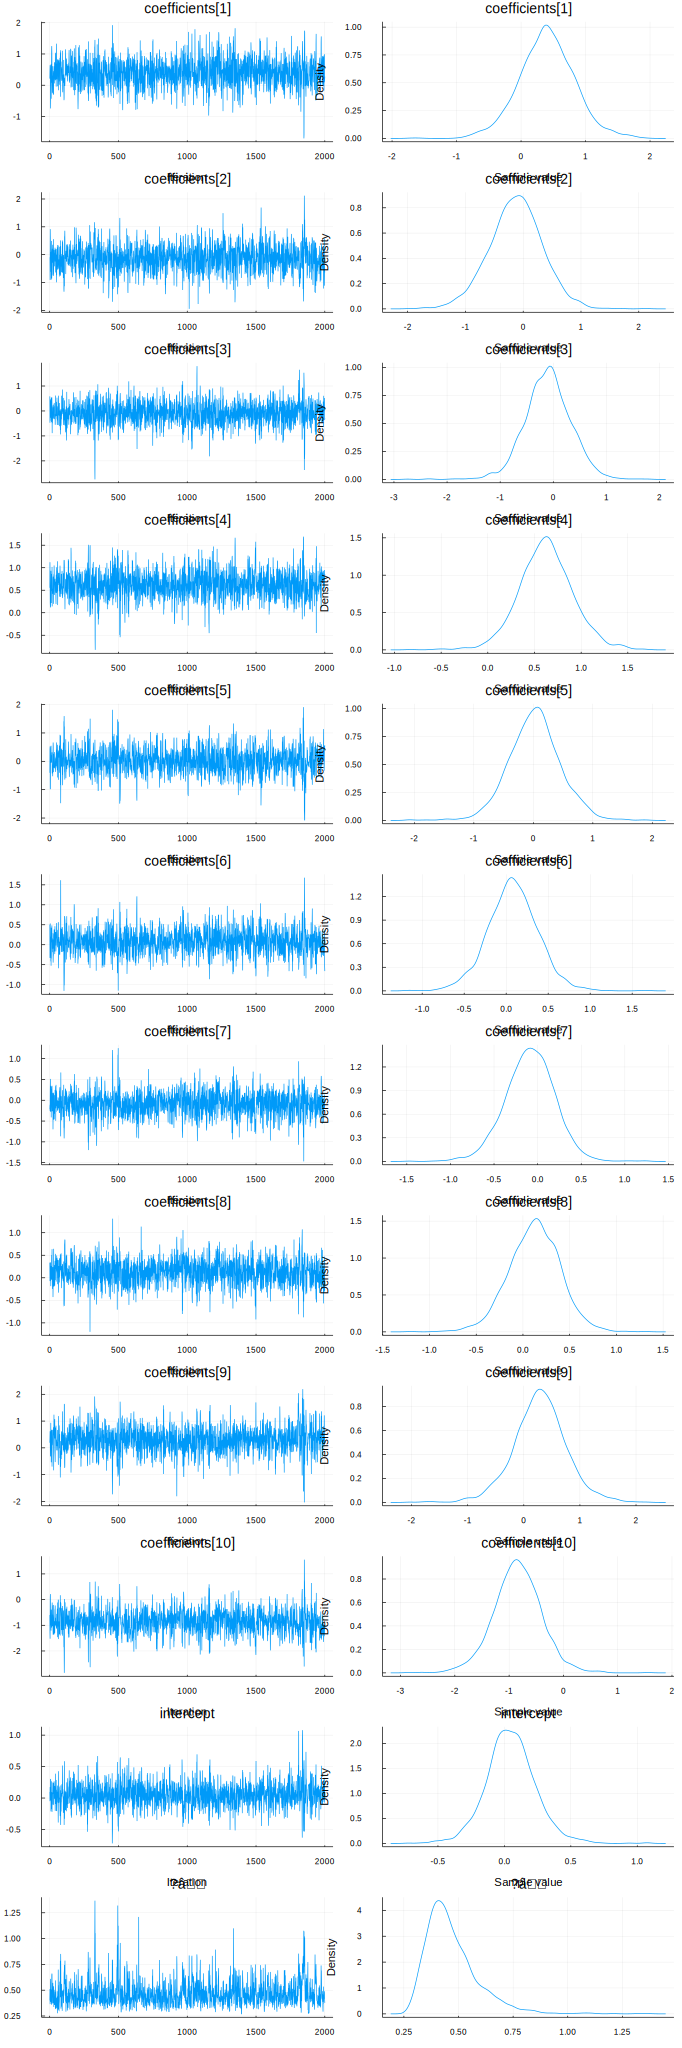

In [7]:
plot(chain)

It looks like each of our parameters has converged. We can check our numerical esimates using `describe(chain)`, as below.

In [8]:
describe(chain)

2-element Array{ChainDataFrame,1}

Summary Statistics
        parameters     mean     std  naive_se    mcse        ess   r_hat
  ────────────────  ───────  ──────  ────────  ──────  ─────────  ──────
   coefficients[1]   0.4016  0.4323    0.0097  0.0126  1418.0304  1.0027
   coefficients[2]  -0.1277  0.4637    0.0104  0.0135  1181.7039  1.0005
   coefficients[3]  -0.1022  0.4395    0.0098  0.0109  1431.9877  0.9995
   coefficients[4]   0.6234  0.2929    0.0065  0.0084  1283.4786  0.9999
   coefficients[5]   0.0228  0.4389    0.0098  0.0122   952.5486  1.0011
   coefficients[6]   0.0806  0.3023    0.0068  0.0070  1172.3970  1.0005
   coefficients[7]  -0.0882  0.2855    0.0064  0.0107  1301.0501  0.9995
   coefficients[8]   0.1230  0.2741    0.0061  0.0092  1205.5582  0.9996
   coefficients[9]   0.2870  0.4770    0.0107  0.0200  1142.3295  1.0007
  coefficients[10]  -0.8466  0.4473    0.0100  0.0155  1028.5133  0.9999
         intercept   0.0488  0.1879    0.0042  0.0069  1318.5615  0.99

## Comparing to OLS

A satisfactory test of our model is to evaluate how well it predicts. Importantly, we want to compare our model to existing tools like OLS. The code below uses the [GLM.jl]() package to generate a traditional OLS multiple regression model on the same data as our probabalistic model.

In [9]:
# Import the GLM package.
using GLM

# Perform multiple regression OLS.
ols = lm(@formula(MPG ~ Cyl + Disp + HP + DRat + WT + QSec + VS + AM + Gear + Carb), train_cut)

# Store our predictions in the original dataframe.
train_cut.OLSPrediction = unstandardize(GLM.predict(ols), data.MPG);
test_cut.OLSPrediction = unstandardize(GLM.predict(ols, test_cut), data.MPG);

The function below accepts a chain and an input matrix and calculates predictions. We use the mean observation of each parameter in the model starting with sample 200, which is where the warm-up period for the NUTS sampler ended.

In [10]:
# Make a prediction given an input vector.
function prediction(chain, x)
    p = get_params(chain[200:end, :, :])
    α = mean(p.intercept)
    β = collect(mean.(p.coefficients))
    return  α .+ x * β
end

prediction (generic function with 1 method)

When we make predictions, we unstandardize them so they're more understandable. We also add them to the original dataframes so they can be placed in context.

In [11]:
# Calculate the predictions for the training and testing sets.
train_cut.BayesPredictions = unstandardize(prediction(chain, train), data.MPG);
test_cut.BayesPredictions = unstandardize(prediction(chain, test), data.MPG);

# Unstandardize the dependent variable.
train_cut.MPG = unstandardize(train_cut.MPG, data.MPG);
test_cut.MPG = unstandardize(test_cut.MPG, data.MPG);

# Show the first side rows of the modified dataframe.
first(test_cut, 6)

,MPG,Cyl,Disp,HP,DRat,WT,QSec,VS
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,116.195,1.01488,0.591245,0.0483133,-0.835198,0.222544,-0.307089,-0.868028
2,114.295,1.01488,0.962396,1.4339,0.249566,0.636461,-1.36476,-0.868028
3,120.195,1.01488,1.36582,0.412942,-0.966118,0.641571,-0.446992,-0.868028
4,128.295,-1.22486,-1.22417,-1.17684,0.904164,-1.31048,0.588295,1.11604
5,126.995,-1.22486,-0.890939,-0.812211,1.55876,-1.10097,-0.642858,-0.868028
6,131.395,-1.22486,-1.09427,-0.491337,0.324377,-1.74177,-0.530935,1.11604


Now let's evaluate the loss for each method, and each prediction set. We will use sum of squared error function to evaluate loss, given by 

$$
\text{SSE} = \sum{(y_i - \hat{y_i})^2}
$$

where $y_i$ is the actual value (true MPG) and $\hat{y_i}$ is the predicted value using either OLS or Bayesian linear regression. A lower SSE indicates a closer fit to the data.

In [12]:
bayes_loss1 = sum((train_cut.BayesPredictions - train_cut.MPG).^2)
ols_loss1 = sum((train_cut.OLSPrediction - train_cut.MPG).^2)

bayes_loss2 = sum((test_cut.BayesPredictions - test_cut.MPG).^2)
ols_loss2 = sum((test_cut.OLSPrediction - test_cut.MPG).^2)

println("Training set:
    Bayes loss: $bayes_loss1
    OLS loss: $ols_loss1
Test set: 
    Bayes loss: $bayes_loss2
    OLS loss: $ols_loss2")

Training set:
    Bayes loss: 67.61488347514008
    OLS loss: 67.56037474764642
Test set: 
    Bayes loss: 278.859606131571
    OLS loss: 270.9481307076011


As we can see above, OLS and our Bayesian model fit our training set about the same. This is to be expected, given that it is our training set. However, the Bayesian linear regression model is less able to predict out of sample -- this is likely due to our selection of priors, and that fact that point estimates were used to forecast instead of the true posteriors.